# Lesson 2: sMRI Image Cleanup

## Objectives
- Visualize structural MR images (NifTi)

## Python Requirements
- [matplotlib](https://matplotlib.org/)
- [nibabel](https://nipy.org/nibabel/)
- [nilearn](https://nilearn.github.io/index.html)
- [nipype](https://nipype.readthedocs.io/en/0.11.0/index.html) (Optional)

## Useful resources:
- FreeSurfer output [description](https://surfer.nmr.mgh.harvard.edu/fswiki/ReconAllTableStableV5.3)
- Nipype [snippets](https://miykael.github.io/nipype_tutorial/)

## Dataset used:
- [AOMIC](https://nilab-uva.github.io/AOMIC.github.io/): the Amsterdam Open MRI [Collection](https://openneuro.org/datasets/ds002790/versions/2.0.0)

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nibabel as nib
import nilearn
from nilearn import datasets
from nilearn import plotting
from nilearn.masking import apply_mask
import os
from bids import BIDSLayout

## Dataset

### Here we will be using a subset of [AOMIC](https://nilab-uva.github.io/AOMIC.github.io/): the Amsterdam Open MRI Collection from [OpenNeuro](https://openneuro.org/datasets/ds002790/versions/2.0.0).

<img src="../fig/episode_2/AOMIC_openneuro.png" width="1000">

## The anatomical data along with the processed derivatives are conveninetly organized in BIDS format! 

|      Scans  | fMRIPrep Output | FreeSurfer Output |
| :-------------: | :-----------: |
| <img src="../fig/episode_2/AOMIC_BIDS_level_1.png" width="500"> | <img src="../fig/episode_2/AOMIC_BIDS_fmriprep.png" width="420"> |  <img src="../fig/episode_2/AOMIC_BIDS_level_2.png" width="415"> |

## We have already downloaded data for 'sub-0001' or 'sub-0002' in the local_data/AOMIC directory. 

### If you would like to try with more subjects you can use "aws" commands below to download more subjects either in the terminal or in the notebook. This can be slow depending on how much data you are downloading / Binder instance / local internet connection. Beware the derivative files (i.e. processed output) can be huge. 


In [2]:
### Uncomment line below to download anatomical subject data for sub-0003
# !aws s3 sync --no-sign-request s3://openneuro.org/ds002790 ../local_data/AOMIC/ --exclude "*" --include "sub-0003/anat/*"

### Uncomment line below to download freesurfer subject data for sub-0003
# !aws s3 sync --no-sign-request s3://openneuro.org/ds002790 ../local_data/AOMIC/ --exclude "*" --include "derivatives/freesurfer/sub-0003/mri/*"


## Local paths

### The root data directory tree

In [3]:
!tree -d -C ../local_data/AOMIC

../local_data/AOMIC
├── derivatives
│   ├── fmriprep
│   │   ├── sub-0001
│   │   │   └── anat
│   │   ├── sub-0002
│   │   │   └── anat
│   │   ├── sub-0003
│   │   │   └── anat
│   │   ├── sub-0004
│   │   │   └── anat
│   │   ├── sub-0005
│   │   │   └── anat
│   │   ├── sub-0006
│   │   │   └── anat
│   │   ├── sub-0007
│   │   │   └── anat
│   │   ├── sub-0008
│   │   │   └── anat
│   │   ├── sub-0009
│   │   │   └── anat
│   │   └── sub-0010
│   │       └── anat
│   ├── freesurfer
│   │   ├── fsaverage5
│   │   │   ├── mri
│   │   │   │   └── transforms
│   │   │   ├── stats
│   │   │   └── surf
│   │   ├── sub-0001
│   │   │   ├── mri
│   │   │   │   ├── orig
│   │   │   │   └── transforms
│   │   │   ├── stats
│   │   │   └── surf
│   │   ├── sub-0002
│   │   │   └── mri
│   │   │       ├── orig
│   │   │       └── transforms
│   │   └── sub-0003
│   │       └── mri
│   │           ├── orig
│   │           └── transforms
│   ├── fs_stats
│   └── vbm
│       ├── all_subjects
│  

### Derivatives (i.e. processed data)

In [4]:
!tree -C ../local_data/AOMIC/derivatives/fmriprep/

../local_data/AOMIC/derivatives/fmriprep/
├── dataset_description.json
├── sub-0001
│   └── anat
│       ├── sub-0001_desc-aparcaseg_dseg.nii.gz
│       ├── sub-0001_desc-aseg_dseg.nii.gz
│       ├── sub-0001_desc-brain_mask.json
│       ├── sub-0001_desc-brain_mask.nii.gz
│       ├── sub-0001_desc-preproc_T1w.json
│       ├── sub-0001_desc-preproc_T1w.nii.gz
│       ├── sub-0001_dseg.nii.gz
│       ├── sub-0001_from-MNI152NLin2009cAsym_to-T1w_mode-image_xfm.h5
│       ├── sub-0001_from-orig_to-T1w_mode-image_xfm.txt
│       ├── sub-0001_from-T1w_to-fsnative_mode-image_xfm.txt
│       ├── sub-0001_from-T1w_to-MNI152NLin2009cAsym_mode-image_xfm.h5
│       ├── sub-0001_hemi-L_inflated.surf.gii
│       ├── sub-0001_hemi-L_midthickness.surf.gii
│       ├── sub-0001_hemi-L_pial.surf.gii
│       ├── sub-0001_hemi-L_smoothwm.surf.gii
│       ├── sub-0001_hemi-R_inflated.surf.gii
│       ├── sub-0001_hemi-R_midthickness.surf.gii
│       ├── sub-0001_hemi-R_pial.surf.gii
│       ├── sub-0001_he

## One way of reading data... 

In [5]:
local_data_dir = '../local_data/'

subject_id = 'sub-0001' # pick 'sub-0001' or 'sub-0002'

fmriprep_output_dir = local_data_dir + 'AOMIC/derivatives/fmriprep/{}/anat/'.format(subject_id)

freesurfer_output_dir = local_data_dir + 'AOMIC/derivatives/freesurfer/{}/mri/'.format(subject_id)

print('Using {}'.format(subject_id))
subject_T1 = local_data_dir + 'AOMIC/{}/anat/{}_T1w.nii.gz'.format(subject_id,subject_id)
subject_T1_N4_corrected = fmriprep_output_dir + 'sub-0001_desc-preproc_T1w.nii.gz'

Using sub-0001


## Using `pybids` package!

In [21]:
bids_data_dir = '../local_data/AOMIC'
bids_layout = BIDSLayout(bids_data_dir, derivatives=True)

subject_list = bids_layout.get_subjects()
print('Available subjectsin the BIDS dataset:\n{}'.format(subject_list))

/home/nikhil/anaconda3/envs/parkinsons/lib/python3.8/site-packages/bids/layout/models.py:148: FutureWarning: The 'extension' entity currently excludes the leading dot ('.'). As of version 0.14.0, it will include the leading dot. To suppress this warning and include the leading dot, use `bids.config.set_option('extension_initial_dot', True)`.
  warnings.warn("The 'extension' entity currently excludes the leading dot ('.'). "
Available subjectsin the BIDS dataset:
['0001', '0002', '0003', '0004', '0005', '0006', '0007', '0008', '0009', '0010']


In [7]:
subject_T1 = bids_layout.get(subject="0001", datatype='anat', scope='raw',
                            extension='nii.gz', return_type='filename')[0]

subject_T1_N4_corrected = bids_layout.get(subject="0001", scope="derivatives", datatype='anat', suffix='T1w',
                               desc='preproc', extension='nii.gz', return_type='filename')[0]


subject_T1, subject_T1_N4_corrected                    

('/home/nikhil/projects/SDC-BIDS-sMRI/local_data/AOMIC/sub-0001/anat/sub-0001_T1w.nii.gz',
 '/home/nikhil/projects/SDC-BIDS-sMRI/local_data/AOMIC/derivatives/fmriprep/sub-0001/anat/sub-0001_desc-preproc_T1w.nii.gz')

## Clean-up tasks:
- Bias correction (intensity normalization)
- Brain extraction 

### If you want to run the preprocessing tasks, you will need ANTs and Nipype on your machine. These tasks are computationally demanding so we can skip them at the moment. But you can use the code snippets to try them later! 


## Bias correction


### s/fMRIPrep implementation [Using ANTs and NiPype](https://pythonhosted.org/nipype/interfaces/generated/nipype.interfaces.ants.segmentation.html#n4biasfieldcorrection)
- This requires local installation of ANTs + nipype or [s/fMRIPrep Docker](https://fmriprep.org/en/stable/docker.html#running-fmriprep-with-the-fmriprep-docker-wrapper)
- Give it a try using the snippet below when you have the ANTs + nipype setup ready!


In [8]:
# import nipype.pipeline.engine as pe                       
# from nipype.interfaces.utility import IdentityInterface
# from nipype.interfaces.ants import N4BiasFieldCorrection
# from nipype.interfaces.io import SelectFiles, DataSink


# my_brain_image = '/path/to/T1.nii.gz'

# n4 = N4BiasFieldCorrection()
# n4.inputs.dimension = 3
# n4.inputs.input_image = my_brain_image
# n4.inputs.bspline_fitting_distance = 300
# n4.inputs.shrink_factor = 3
# n4.inputs.n_iterations = [50,50,30,20]
# n4.inputs.output_image = my_brain_image.replace('.nii.gz', '_N4_corrected_nii.gz')

# n4.run() 

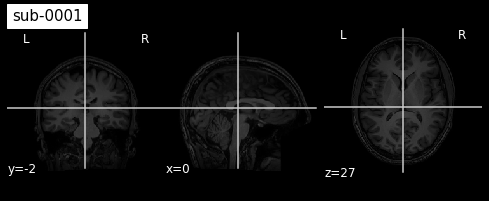

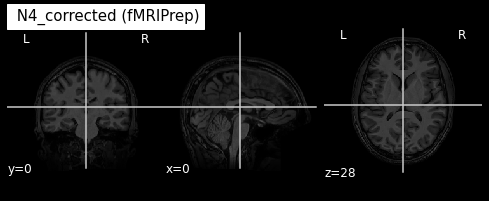

In [9]:
# Plot waw scan
plotting.plot_anat(subject_T1, title=subject_id)

# Plot Corrected image
plotting.plot_anat(subject_T1_N4_corrected, title=' N4_corrected (fMRIPrep)')

## Using precomputed FreeSurfer output

### Compare the original and corrected images

### Files used:
- orig.mgz: input (raw) T1 image
- nu.mgz: [Output](https://surfer.nmr.mgh.harvard.edu/fswiki/nuintensitycor) of non-parametric Non-uniform intensity Normalization (N3)
- T1.mgz: [Output](https://surfer.nmr.mgh.harvard.edu/fswiki/normalization) of intensity normalization of the orig volume to correct for fluctuations in intensity that would otherwise make intensity-based segmentation much more difficult. Intensities for all voxels are scaled so that the mean intensity of the white matter is 110.


In [10]:
T1_orig = freesurfer_output_dir + 'orig.mgz'
T1_corrected = freesurfer_output_dir + 'nu.mgz'
T1_normalized = freesurfer_output_dir + 'T1.mgz'


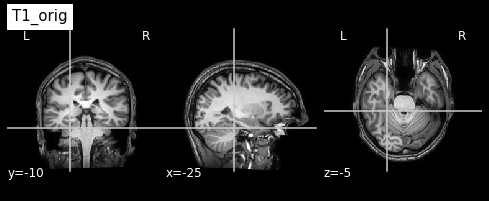

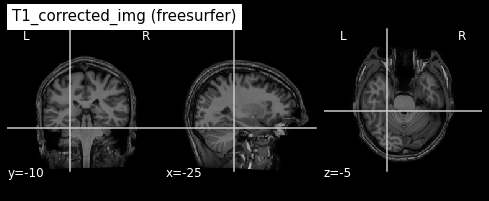

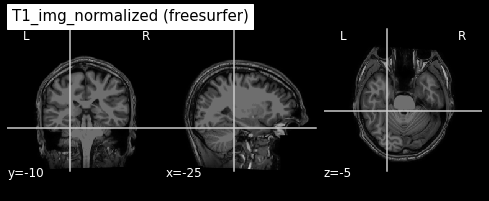

In [12]:
cut_coords = (-25,-10,-5)
plotting.plot_anat(T1_orig, title="T1_orig", cut_coords=cut_coords, vmax=255)
plotting.plot_anat(T1_corrected, title="T1_corrected_img (freesurfer)", cut_coords=cut_coords, vmax=255)
plotting.plot_anat(T1_normalized, title="T1_img_normalized (freesurfer)", cut_coords=cut_coords, vmax=255)

## plot intensity histogram

In [14]:
T1_data_orig = nib.load(T1_orig).get_fdata()
T1_data_corrected = nib.load(T1_corrected).get_fdata()
T1_data_normalized = nib.load(T1_normalized).get_fdata()

print("Data shapes, orig: {}, corrected: {}, normalized: {}".format(T1_data_orig.shape, T1_data_corrected.shape, T1_data_normalized.shape))

print("Intensity ranges, orig, min:{}, max:{}, corrected, min:{}, max:{},  normalized, min:{}, max:{}".format(T1_data_orig.min(), T1_data_orig.max(), T1_data_corrected.min(), T1_data_corrected.max(), T1_data_normalized.min(), T1_data_normalized.max()))

# non_zero
T1_data_orig = T1_data_orig.ravel()
T1_data_orig = T1_data_orig[np.nonzero(T1_data_orig)]

T1_data_corrected = T1_data_corrected.ravel()
T1_data_corrected = T1_data_corrected[np.nonzero(T1_data_corrected)]

T1_data_normalized = T1_data_normalized.ravel()
T1_data_normalized = T1_data_normalized[np.nonzero(T1_data_normalized)]


Data shapes, orig: (256, 256, 256), corrected: (256, 256, 256), normalized: (256, 256, 256)
Intensity ranges, orig, min:0.0, max:255.0, corrected, min:0.0, max:203.0,  normalized, min:0.0, max:209.0


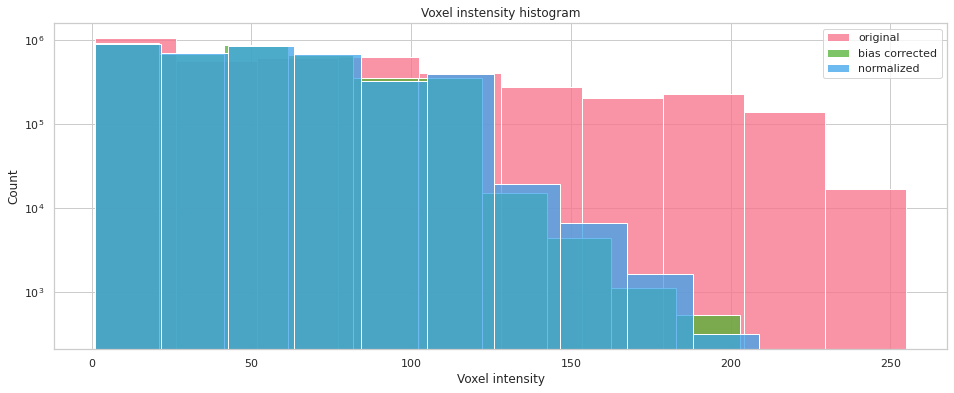

In [15]:
sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 2.5})

palette = sns.color_palette("husl", 3)

with sns.axes_style("whitegrid"):
    plt.figure(figsize=(16, 6))
    g = sns.histplot(T1_data_orig, bins=10, kde=False, color=palette[0], log_scale=(False, True), label='original')
    g = sns.histplot(T1_data_corrected, bins=10, kde=False, color=palette[1], log_scale=(False, True), label='bias corrected')
    g = sns.histplot(T1_data_normalized, bins=10, kde=False, color=palette[2], log_scale=(False, True), label='normalized')

    plt.legend()
    plt.xlabel('Voxel intensity')
    plt.title('Voxel instensity histogram')

## Brain extraction
### s/fMRIPrep implementation [Using ANTs and NiPype](https://pythonhosted.org/nipype/interfaces/generated/nipype.interfaces.ants.segmentation.html#brainextraction)
- This requires local installation of ANTs + nipype or [s/fMRIPrep Docker](https://fmriprep.org/en/stable/docker.html#running-fmriprep-with-the-fmriprep-docker-wrapper)
- Give it a try using the snippet below when you have the ANTs + nipype setup ready!


In [ ]:
# from nipype.interfaces.ants.segmentation import BrainExtraction
# brainextraction = BrainExtraction()
# brainextraction.inputs.dimension = 3
# brainextraction.inputs.anatomical_image ='T1.nii.gz'
# brainextraction.inputs.brain_template = 'study_template.nii.gz'
# brainextraction.inputs.brain_probability_mask ='ProbabilityMaskOfStudyTemplate.nii.gz'
# print(brainextraction.cmdline)

##'antsBrainExtraction.sh -a T1.nii.gz -m ProbabilityMaskOfStudyTemplate.nii.gz -e study_template.nii.gz -d 3 -s nii.gz -o highres001_'


## Read local data using `pybids` package!

In [16]:
subject_T1_N4_corrected = bids_layout.get(subject="0001", scope="derivatives", datatype='anat', suffix='T1w',
                               desc='preproc', extension='nii.gz', return_type='filename')[0]

subject_T1_brain_mask = bids_layout.get(subject="0001", scope="derivatives", datatype='anat', suffix='mask',
                               desc='brain', extension='nii.gz', return_type='filename')[0]

subject_T1_brain_mask, subject_T1_N4_corrected 

('/home/nikhil/projects/SDC-BIDS-sMRI/local_data/AOMIC/derivatives/fmriprep/sub-0001/anat/sub-0001_desc-brain_mask.nii.gz',
 '/home/nikhil/projects/SDC-BIDS-sMRI/local_data/AOMIC/derivatives/fmriprep/sub-0001/anat/sub-0001_desc-preproc_T1w.nii.gz')

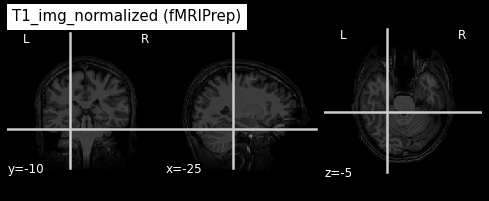

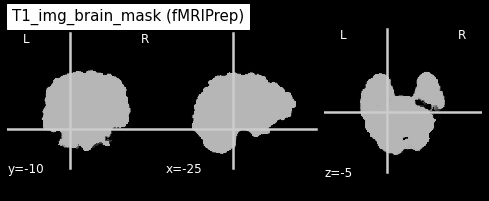

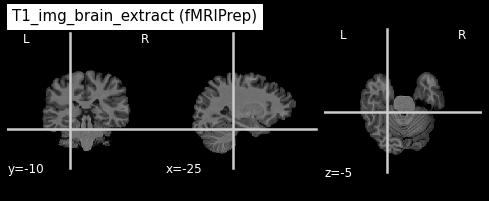

In [17]:
T1_img_normalized = nib.load(subject_T1_N4_corrected)
T1_img_brain_mask = nib.load(subject_T1_brain_mask)
masked_data = T1_img_normalized.get_fdata() * T1_img_brain_mask.get_fdata()

T1_img_brain_extract = nib.Nifti1Image(masked_data, T1_img_normalized.affine)

cut_coords = (-25,-10,-5)

plotting.plot_anat(T1_img_normalized, title="T1_img_normalized (fMRIPrep)", cut_coords=cut_coords)
plotting.plot_anat(T1_img_brain_mask, title="T1_img_brain_mask (fMRIPrep)", cut_coords=cut_coords)
plotting.plot_anat(T1_img_brain_extract, title="T1_img_brain_extract (fMRIPrep)", cut_coords=cut_coords)

## Using precomputed FreeSurfer output

### Compare the original and corrected images

### Files used:
- T1.mgz: Normalized MR image
- brainmask.mgz: brain extracted (i.e. skull stripped MR image)

In [18]:
T1_normalized = freesurfer_output_dir + 'T1.mgz'
T1_brain_extract = freesurfer_output_dir + 'brainmask.mgz'

T1_img_normalized = nib.load(T1_normalized)
T1_img_brain_extract = nib.load(T1_brain_extract)

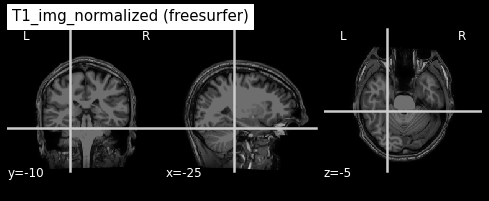

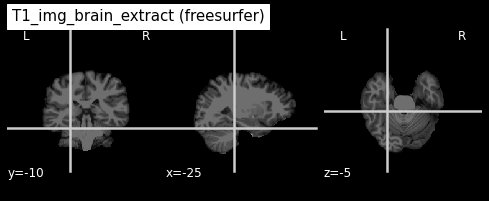

In [19]:
cut_coords = (-25,-10,-5)

plotting.plot_anat(T1_img_normalized, title="T1_img_normalized (freesurfer)", cut_coords=cut_coords, vmax=255)
plotting.plot_anat(T1_img_brain_extract, title="T1_img_brain_extract (freesurfer)", cut_coords=cut_coords, vmax=255)